In [142]:
# COMPREHENSIVE EPM-E4 DATA PROCESSING PIPELINE
# Complete end-to-end extraction of all physiological data with emotion-based stress detection

print("="*80)
print("COMPREHENSIVE EPM-E4 DATA PROCESSING PIPELINE")
print("="*80)
print("Starting complete extraction of all EPM-E4 physiological data...")
print("This will process ALL emotion-labeled files with ALL modalities")

# Essential imports for complete processing
import sys
import os
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Setup paths
BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
EPM_E4_RAW_PATH = BASE_PATH / 'data' / 'datasets' / 'epm_e4' / 'raw'

# Output directories  
OUTPUT_DIRS = {
    'processed': BASE_PATH / 'data' / 'processed',
    'figures': BASE_PATH / 'data' / 'figures' / 'nb_02_epm_e4_processing'
}

for dir_path in OUTPUT_DIRS.values():
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"EPM-E4 data path: {EPM_E4_RAW_PATH}")
print(f"Output directories configured")
print(f"  - Processed: {OUTPUT_DIRS['processed']}")
print(f"  - Figures: {OUTPUT_DIRS['figures']}")

# Check available files
if EPM_E4_RAW_PATH.exists():
    epm_csv_files = list(EPM_E4_RAW_PATH.rglob('*.csv'))
    print(f"Found {len(epm_csv_files)} CSV files in EPM-E4 dataset")
    for i, file_path in enumerate(sorted(epm_csv_files)[:10]):
        print(f"    {i+1}. {file_path.name}")
    if len(epm_csv_files) > 10:
        print(f"    ... and {len(epm_csv_files) - 10} more files")
else:
    print(" ERROR: EPM-E4 data directory not found!")
    sys.exit(1)

COMPREHENSIVE EPM-E4 DATA PROCESSING PIPELINE
Starting complete extraction of all EPM-E4 physiological data...
This will process ALL emotion-labeled files with ALL modalities
EPM-E4 data path: /home/alvaro-ibarra/smartwatch-stress-detection/data/datasets/epm_e4/raw
Output directories configured
  - Processed: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed
  - Figures: /home/alvaro-ibarra/smartwatch-stress-detection/data/figures/nb_02_epm_e4_processing
Found 1148 CSV files in EPM-E4 dataset
    1. ANGER.csv
    2. FEAR.csv
    3. HAPPINESS.csv
    4. NEUTRAL_ANGER.csv
    5. NEUTRAL_FEAR.csv
    6. NEUTRAL_HAPPINESS.csv
    7. NEUTRAL_SADNESS.csv
    8. SADNESS.csv
    9. ANGER.csv
    10. FEAR.csv
    ... and 1138 more files


In [143]:
# ==============================================================================
# COMPREHENSIVE EPM-E4 FEATURE EXTRACTION
# ==============================================================================

print("="*80)
print("COMPREHENSIVE EPM-E4 FEATURE EXTRACTION")
print("="*80)

print(" Starting comprehensive processing of all EPM-E4 emotion files...")
print(" This will extract features from ALL physiological modalities\n")

# Ensure we have all necessary variables from first cell
try:
    PROCESSED_PATH = OUTPUT_DIRS['processed']
    FIGURES_PATH = OUTPUT_DIRS['figures']
except NameError:
    # Fallback if first cell wasn't run
    from pathlib import Path
    import json
    from tqdm import tqdm
    BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
    PROCESSED_PATH = BASE_PATH / 'data' / 'processed'
    FIGURES_PATH = BASE_PATH / 'data' / 'figures' / 'nb_02_epm_e4_processing'
    PROCESSED_PATH.mkdir(parents=True, exist_ok=True)
    FIGURES_PATH.mkdir(parents=True, exist_ok=True)

all_epm_features = []
processing_summary = {}

# Robust feature extraction function
def extract_comprehensive_features(data, prefix):
    """Extract comprehensive statistical features from a data window"""
    if len(data) == 0:
        return {
            f'{prefix}_mean': 0.0,
            f'{prefix}_std': 0.0,
            f'{prefix}_min': 0.0,
            f'{prefix}_max': 0.0,
            f'{prefix}_median': 0.0,
            f'{prefix}_range': 0.0
        }
    
    features = {
        f'{prefix}_mean': np.mean(data),
        f'{prefix}_std': np.std(data),
        f'{prefix}_min': np.min(data),
        f'{prefix}_max': np.max(data),
        f'{prefix}_median': np.median(data),
        f'{prefix}_range': np.max(data) - np.min(data),
        f'{prefix}_q25': np.percentile(data, 25),
        f'{prefix}_q75': np.percentile(data, 75),
        f'{prefix}_iqr': np.percentile(data, 75) - np.percentile(data, 25)
    }
    
    # Advanced features
    if len(data) > 1:
        features.update({
            f'{prefix}_var': np.var(data),
            f'{prefix}_skew': stats.skew(data),
            f'{prefix}_kurtosis': stats.kurtosis(data)
        })
        
        # Rate of change features
        diff_data = np.diff(data)
        if len(diff_data) > 0:
            features.update({
                f'{prefix}_mean_derivative': np.mean(diff_data),
                f'{prefix}_std_derivative': np.std(diff_data)
            })
    
    return features

# EPM-E4 emotion-to-stress mapping
emotion_stress_mapping = {
    'neutral': 0, 'calm': 0, 'baseline': 0, 'joy': 0, 'happiness': 0, 'positive': 0,
    'anger': 1, 'fear': 1, 'stress': 1, 'sad': 1, 'sadness': 1, 'disgust': 1, 
    'surprise': 1, 'negative': 1, 'arousal': 1
}

# Process EPM-E4 files
if EPM_E4_RAW_PATH.exists():
    epm_csv_files = list(EPM_E4_RAW_PATH.rglob('*.csv'))
    print(f" Found {len(epm_csv_files)} EPM-E4 files to process...")
    
    for file_idx, file_path in enumerate(tqdm(epm_csv_files, desc="Processing EPM-E4 files")):
        try:
            print(f"\n Processing {file_path.name}...")
            
            # Load CSV file
            df = pd.read_csv(file_path)
            print(f"   Loaded file: {df.shape}")
            
            # Find numeric columns (physiological signals)
            numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            if len(numeric_cols) == 0:
                print(f"   ⚠ No numeric columns found, skipping")
                continue
                
            print(f"   Numeric signals: {numeric_cols}")
            
            # Extract features for each signal
            file_features = {
                'file_id': f"EPM_E4_{file_idx:03d}",
                'filename': file_path.name,
                'dataset': 'EPM-E4'
            }
            
            # Extract features from each physiological signal
            for signal_name in numeric_cols:
                signal_data = df[signal_name].values
                
                # Clean signal name for feature prefix
                clean_signal_name = signal_name.lower().replace(' ', '_').replace('-', '_')
                
                # Extract comprehensive features
                signal_features = extract_comprehensive_features(signal_data, clean_signal_name)
                file_features.update(signal_features)
                
                print(f"     - {signal_name}: {len(signal_features)} features extracted")
            
            # Determine emotion and stress label from filename
            filename_lower = file_path.name.lower()
            detected_emotion = None
            stress_label = 0  # Default to low stress
            
            # Check for emotion keywords in filename
            for emotion, stress_val in emotion_stress_mapping.items():
                if emotion in filename_lower:
                    detected_emotion = emotion
                    stress_label = stress_val
                    break
            
            # If no emotion detected, try pattern matching
            if detected_emotion is None:
                if any(word in filename_lower for word in ['stress', 'anger', 'fear', 'negative', 'sad']):
                    stress_label = 1
                    detected_emotion = "inferred_stress"
                else:
                    detected_emotion = "neutral_default"
                    
            file_features['emotion_detected'] = detected_emotion
            file_features['stress_label'] = stress_label
            
            print(f"     - Emotion: {detected_emotion} -> Stress: {stress_label}")
            
            # Add to results
            all_epm_features.append(file_features)
            
            # Update processing summary
            processing_summary[file_path.name] = {
                'shape': df.shape,
                'signals': numeric_cols,
                'emotion': detected_emotion,
                'stress_label': stress_label,
                'feature_count': len([k for k in file_features.keys() if k not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']])
            }
            
        except Exception as e:
            print(f"   Error processing {file_path.name}: {str(e)}")
            continue

print(f"\n Processing complete!")
print(f" Total EPM-E4 samples extracted: {len(all_epm_features)}")

# Convert to DataFrame for analysis
if all_epm_features:
    epm_df = pd.DataFrame(all_epm_features)
    
    print(f"\n EPM-E4 DATASET SUMMARY:")
    print(f"   - Total samples: {len(epm_df)}")
    print(f"   - Number of features: {len([col for col in epm_df.columns if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']])}")
    
    # Emotion/stress distribution
    if 'stress_label' in epm_df.columns:
        stress_dist = epm_df['stress_label'].value_counts()
        print(f"   - Stress distribution: {stress_dist.to_dict()}")
    
    if 'emotion_detected' in epm_df.columns:
        emotion_dist = epm_df['emotion_detected'].value_counts()
        print(f"   - Top emotions: {dict(emotion_dist.head())}")
        
    print(f"\n EPM-E4 feature extraction completed successfully!")
    
    # Save the EPM-E4 dataset
    output_file = PROCESSED_PATH / "epm_e4_features.csv"
    epm_df.to_csv(output_file, index=False)
    print(f" Saved EPM-E4 dataset to: {output_file}")
    
    # Save processing summary
    summary_file = PROCESSED_PATH / "epm_e4_processing_summary.json"
    with open(summary_file, 'w') as f:
        json.dump(processing_summary, f, indent=2, default=str)
    print(f" Saved processing summary to: {summary_file}")

else:
    print(" No EPM-E4 data was extracted!")
    epm_df = None

COMPREHENSIVE EPM-E4 FEATURE EXTRACTION
 Starting comprehensive processing of all EPM-E4 emotion files...
 This will extract features from ALL physiological modalities

 Found 1148 EPM-E4 files to process...


Processing EPM-E4 files:   0%|          | 0/1148 [00:00<?, ?it/s]


 Processing SADNESS.csv...
   Loaded file: (19878, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5288, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     

Processing EPM-E4 files:   1%|          | 10/1148 [00:00<00:33, 34.04it/s]

     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5693, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (6794, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.a

Processing EPM-E4 files:   2%|▏         | 23/1148 [00:00<00:22, 49.83it/s]

     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing HAPPINESS.csv...
   Loaded file: (39503, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21397, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - 

Processing EPM-E4 files:   3%|▎         | 29/1148 [00:00<00:23, 47.89it/s]

   Loaded file: (10064, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50146, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extr

Processing EPM-E4 files:   4%|▎         | 43/1148 [00:00<00:20, 53.52it/s]

     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5682, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5690, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracte

Processing EPM-E4 files:   5%|▍         | 56/1148 [00:01<00:20, 54.07it/s]

     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21479, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (4809, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'emp

Processing EPM-E4 files:   6%|▌         | 68/1148 [00:01<00:20, 52.97it/s]

   Loaded file: (50564, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5615, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:   7%|▋         | 81/1148 [00:01<00:19, 54.19it/s]

   Loaded file: (39687, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21318, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:   8%|▊         | 88/1148 [00:01<00:19, 53.97it/s]

     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50715, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5640, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - e

Processing EPM-E4 files:   9%|▊         | 100/1148 [00:02<00:21, 49.01it/s]

     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5058, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5073, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
 

Processing EPM-E4 files:  10%|▉         | 112/1148 [00:02<00:20, 50.38it/s]

     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing HAPPINESS.csv...
   Loaded file: (39608, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21268, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp'

Processing EPM-E4 files:  10%|█         | 120/1148 [00:02<00:19, 53.51it/s]

   Loaded file: (21242, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (0, 8)
   ⚠ No numeric columns found, skipping

 Processing ANGER.csv...
   Loaded file: (10080, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 featu

Processing EPM-E4 files:  11%|█▏        | 132/1148 [00:02<00:19, 53.12it/s]

     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5531, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5840, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
 

Processing EPM-E4 files:  13%|█▎        | 144/1148 [00:02<00:18, 54.15it/s]

     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21297, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5565, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'emp

Processing EPM-E4 files:  14%|█▎        | 156/1148 [00:03<00:19, 51.79it/s]

     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50669, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5567, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - emp

Processing EPM-E4 files:  14%|█▍        | 163/1148 [00:03<00:17, 56.16it/s]

   Loaded file: (4841, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (4691, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  15%|█▌        | 176/1148 [00:03<00:18, 52.84it/s]

     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21448, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5687, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - em

Processing EPM-E4 files:  16%|█▋        | 188/1148 [00:03<00:18, 52.07it/s]

     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50585, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5571, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - e

Processing EPM-E4 files:  17%|█▋        | 194/1148 [00:03<00:18, 52.60it/s]

   Loaded file: (5602, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_ANGER.csv...
   Loaded file: (5562, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 feat

Processing EPM-E4 files:  18%|█▊        | 206/1148 [00:04<00:18, 50.75it/s]

   Loaded file: (39568, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21286, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:  19%|█▉        | 219/1148 [00:04<00:17, 51.98it/s]

     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5584, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (10419, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empat

Processing EPM-E4 files:  20%|█▉        | 225/1148 [00:04<00:17, 51.70it/s]

   Loaded file: (50436, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5768, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  21%|██        | 238/1148 [00:04<00:17, 53.07it/s]

   Loaded file: (39637, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21282, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:  22%|██▏       | 250/1148 [00:04<00:17, 51.19it/s]

     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50555, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5821, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empa

Processing EPM-E4 files:  23%|██▎       | 262/1148 [00:05<00:17, 51.23it/s]

   Loaded file: (50358, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5675, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  23%|██▎       | 268/1148 [00:05<00:17, 49.07it/s]

   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing HAPPINESS.csv...
   Loaded file: (39427, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion

Processing EPM-E4 files:  25%|██▍       | 282/1148 [00:05<00:15, 54.98it/s]

     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (10071, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (1392, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x:

Processing EPM-E4 files:  26%|██▌       | 294/1148 [00:05<00:16, 52.80it/s]

   Loaded file: (21036, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (6739, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features

Processing EPM-E4 files:  26%|██▌       | 300/1148 [00:05<00:16, 50.81it/s]

   Loaded file: (13050, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50484, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extr

Processing EPM-E4 files:  27%|██▋       | 312/1148 [00:06<00:15, 53.01it/s]

     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5575, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5577, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extract

Processing EPM-E4 files:  28%|██▊       | 325/1148 [00:06<00:16, 50.88it/s]

   Loaded file: (21201, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5530, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features

Processing EPM-E4 files:  29%|██▉       | 331/1148 [00:06<00:15, 53.16it/s]

     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50649, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5264, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - emp

Processing EPM-E4 files:  30%|██▉       | 344/1148 [00:06<00:15, 51.29it/s]

     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (7290, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_ANGER.csv...
   Loaded file: (4597, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
  

Processing EPM-E4 files:  31%|███       | 357/1148 [00:06<00:15, 50.07it/s]

     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21310, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5568, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - e

Processing EPM-E4 files:  32%|███▏      | 364/1148 [00:07<00:15, 51.35it/s]

     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (10108, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50539, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.

Processing EPM-E4 files:  33%|███▎      | 377/1148 [00:07<00:14, 53.48it/s]

   Loaded file: (5791, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (6037, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  34%|███▍      | 390/1148 [00:07<00:14, 53.50it/s]

   Loaded file: (21382, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5911, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features

Processing EPM-E4 files:  35%|███▌      | 402/1148 [00:07<00:13, 53.29it/s]

   Loaded file: (50463, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5206, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  36%|███▌      | 408/1148 [00:07<00:14, 51.57it/s]

   Loaded file: (39665, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21423, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:  37%|███▋      | 420/1148 [00:08<00:14, 50.83it/s]

     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (10185, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (51059, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc

Processing EPM-E4 files:  38%|███▊      | 432/1148 [00:08<00:14, 50.43it/s]

   Loaded file: (50503, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5695, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  39%|███▊      | 444/1148 [00:08<00:14, 49.67it/s]

   Loaded file: (39638, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21461, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:  39%|███▉      | 450/1148 [00:08<00:13, 51.61it/s]

   Loaded file: (21268, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5581, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features

Processing EPM-E4 files:  40%|████      | 462/1148 [00:08<00:13, 52.67it/s]

     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5579, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5591, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
 

Processing EPM-E4 files:  41%|████▏     | 474/1148 [00:09<00:12, 52.57it/s]

     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing HAPPINESS.csv...
   Loaded file: (39826, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21448, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     -

Processing EPM-E4 files:  42%|████▏     | 487/1148 [00:09<00:12, 54.11it/s]

     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5571, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (10079, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.

Processing EPM-E4 files:  43%|████▎     | 493/1148 [00:09<00:13, 49.63it/s]

   Loaded file: (50519, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5513, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  44%|████▍     | 505/1148 [00:09<00:13, 48.41it/s]

   Loaded file: (5581, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5492, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  45%|████▍     | 511/1148 [00:09<00:12, 51.03it/s]

     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21640, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5584, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'emp

Processing EPM-E4 files:  46%|████▌     | 523/1148 [00:10<00:12, 50.27it/s]

     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5659, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (9957, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.a

Processing EPM-E4 files:  47%|████▋     | 535/1148 [00:10<00:11, 51.88it/s]

   Loaded file: (50458, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (4980, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  48%|████▊     | 547/1148 [00:10<00:12, 49.79it/s]

   Loaded file: (39797, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21381, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:  48%|████▊     | 553/1148 [00:10<00:12, 46.93it/s]

     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21562, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (5769, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - 

Processing EPM-E4 files:  49%|████▉     | 564/1148 [00:11<00:13, 44.61it/s]

     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing ANGER.csv...
   Loaded file: (10288, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50571, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.

Processing EPM-E4 files:  50%|█████     | 575/1148 [00:11<00:11, 48.19it/s]

     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR.csv...
   Loaded file: (50760, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5704, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - emp

Processing EPM-E4 files:  51%|█████     | 580/1148 [00:11<00:12, 44.46it/s]

   Loaded file: (50671, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5524, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  51%|█████▏    | 591/1148 [00:11<00:11, 47.43it/s]

   Loaded file: (5628, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: neutral -> Stress: 0

 Processing NEUTRAL_SADNESS.csv...
   Loaded file: (5890, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  52%|█████▏    | 602/1148 [00:11<00:11, 46.43it/s]

   Loaded file: (39665, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: happiness -> Stress: 0

 Processing SADNESS.csv...
   Loaded file: (21280, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 featur

Processing EPM-E4 files:  54%|█████▎    | 615/1148 [00:12<00:10, 50.77it/s]

   Loaded file: (18987, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: sad -> Stress: 1

 Processing NEUTRAL_FEAR.csv...
   Loaded file: (4811, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features

Processing EPM-E4 files:  54%|█████▍    | 621/1148 [00:12<00:10, 50.32it/s]

   Loaded file: (50667, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 features extracted
     - Emotion: fear -> Stress: 1

 Processing NEUTRAL_HAPPINESS.csv...
   Loaded file: (5832, 8)
   Numeric signals: ['empatica.acc.x', 'empatica.acc.y', 'empatica.acc.z', 'empatica.hr', 'empatica.bvp', 'empatica.eda', 'empatica.temp']
     - empatica.acc.x: 14 features extracted
     - empatica.acc.y: 14 features extracted
     - empatica.acc.z: 14 features extracted
     - empatica.hr: 14 features extracted
     - empatica.bvp: 14 features extracted
     - empatica.eda: 14 features extracted
     - empatica.temp: 14 fe

Processing EPM-E4 files:  55%|█████▍    | 628/1148 [00:12<00:11, 44.82it/s]

   Loaded file: (32201, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  55%|█████▌    | 633/1148 [00:13<00:33, 15.42it/s]

   Loaded file: (91793, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  56%|█████▌    | 639/1148 [00:13<00:30, 16.62it/s]

   Loaded file: (54959, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  56%|█████▌    | 642/1148 [00:14<00:52,  9.71it/s]

   Loaded file: (33200, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  57%|█████▋    | 650/1148 [00:14<00:35, 14.15it/s]

     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing FEAR_mindMonitor_2021-06-28--11-05-39.csv...
   Loaded file: (113826, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8

Processing EPM-E4 files:  57%|█████▋    | 653/1148 [00:15<00:57,  8.56it/s]

   Loaded file: (55359, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  58%|█████▊    | 661/1148 [00:16<00:47, 10.35it/s]

   Loaded file: (113763, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  58%|█████▊    | 663/1148 [00:16<00:57,  8.46it/s]

     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features extracted
     - Beta_TP9: 14 features extracted
     - Beta_AF7: 14 features extracted
     - Beta_AF8: 14 features extracted
     - Beta_TP10: 14 features extracted
     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features ex

Processing EPM-E4 files:  58%|█████▊    | 665/1148 [00:16<00:54,  8.91it/s]

     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing TEMP.csv...
   Loaded file: (6929, 1)
   Numeric signals: ['1625559275.000000']
     - 1625559275.000000: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing IBI.csv...
   Loaded file: (2168, 2)
   Numeric signals: ['1625559275.000000', ' IBI']
     - 1625559275.000000: 14 features extracted
     -  IBI: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing ACC.csv...
   Loaded file: (55423, 3)
   Numeric signals: ['1625559275.000000', ' 1625559275.000000', ' 1625559275.000000.1']
     - 1625559275.000000: 14 features extracted
     -  1625559275.00

Processing EPM-E4 files:  59%|█████▊    | 672/1148 [00:17<00:36, 12.88it/s]

     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features extracted
     - Beta_TP9: 14 features extracted
     - Beta_AF7: 14 features extracted
     - Beta_AF8: 14 features extracted
     - Beta_TP10: 14 features extracted
     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
  

Processing EPM-E4 files:  59%|█████▊    | 674/1148 [00:17<00:55,  8.54it/s]

   Loaded file: (55696, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  59%|█████▉    | 676/1148 [00:18<00:59,  7.87it/s]

   Loaded file: (93112, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  59%|█████▉    | 683/1148 [00:18<00:45, 10.13it/s]

   Loaded file: (113480, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  60%|█████▉    | 685/1148 [00:19<00:51,  8.91it/s]

     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing HAPPINESS_mindMonitor_2021-06-23--16-17-27.csv...


Processing EPM-E4 files:  60%|█████▉    | 687/1148 [00:19<00:58,  7.86it/s]

   Loaded file: (90452, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  60%|██████    | 694/1148 [00:19<00:35, 12.84it/s]

   Loaded file: (31306, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  61%|██████    | 696/1148 [00:20<00:50,  8.98it/s]

   Loaded file: (53987, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  61%|██████    | 698/1148 [00:20<00:59,  7.56it/s]

   Loaded file: (112095, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  61%|██████▏   | 705/1148 [00:21<00:45,  9.70it/s]

   Loaded file: (113931, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  62%|██████▏   | 707/1148 [00:21<00:59,  7.46it/s]

   Loaded file: (55522, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  62%|██████▏   | 708/1148 [00:21<01:00,  7.31it/s]

     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing TEMP.csv...
   Loaded file: (7289, 1)
   Numeric signals: ['1624954905.000000']
     - 1624954905.000000: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing IBI.csv...
   Loaded file: (1950, 2)
   Numeric signals: ['1624954905.000000', ' IBI']
     - 1624954905.000000: 14 features extracted
     -  IBI: 14 features extracte

Processing EPM-E4 files:  62%|██████▏   | 716/1148 [00:22<00:39, 10.91it/s]

   Loaded file: (91966, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  63%|██████▎   | 718/1148 [00:22<00:57,  7.46it/s]

   Loaded file: (114704, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  63%|██████▎   | 719/1148 [00:23<00:58,  7.27it/s]

   Loaded file: (33002, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  63%|██████▎   | 727/1148 [00:23<00:40, 10.48it/s]

   Loaded file: (113740, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  64%|██████▎   | 729/1148 [00:24<00:47,  8.83it/s]

     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features extracted
     - Beta_TP9: 14 features extracted
     - Beta_AF7: 14 features extracted
     - Beta_AF8: 14 features extracted
     - Beta_TP10: 14 features extracted
     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
  

Processing EPM-E4 files:  64%|██████▎   | 730/1148 [00:24<00:57,  7.31it/s]

   Loaded file: (93410, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  64%|██████▍   | 738/1148 [00:24<00:38, 10.74it/s]

   Loaded file: (91886, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  64%|██████▍   | 740/1148 [00:25<00:55,  7.40it/s]

   Loaded file: (114330, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  65%|██████▍   | 741/1148 [00:25<00:55,  7.35it/s]

   Loaded file: (33619, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  65%|██████▌   | 749/1148 [00:25<00:30, 13.03it/s]

   Loaded file: (31298, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  65%|██████▌   | 751/1148 [00:26<00:51,  7.68it/s]

   Loaded file: (112773, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  66%|██████▌   | 753/1148 [00:26<00:50,  7.77it/s]

   Loaded file: (54992, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  66%|██████▌   | 760/1148 [00:27<00:33, 11.61it/s]

   Loaded file: (55398, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  66%|██████▋   | 762/1148 [00:27<00:45,  8.43it/s]

   Loaded file: (89659, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  67%|██████▋   | 764/1148 [00:28<00:55,  6.96it/s]

   Loaded file: (114011, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  67%|██████▋   | 771/1148 [00:28<00:40,  9.27it/s]

   Loaded file: (114364, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  67%|██████▋   | 773/1148 [00:29<00:52,  7.09it/s]

   Loaded file: (92066, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  67%|██████▋   | 774/1148 [00:29<00:52,  7.06it/s]

   Loaded file: (32808, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  68%|██████▊   | 782/1148 [00:30<00:36, 10.09it/s]

   Loaded file: (113658, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  68%|██████▊   | 784/1148 [00:30<00:47,  7.61it/s]

   Loaded file: (91827, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  68%|██████▊   | 785/1148 [00:30<00:47,  7.62it/s]

     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features extracted
     - Beta_TP9: 14 features extracted
     - Beta_AF7: 14 features extracted
     - Beta_AF8: 14 features extracted
     - Beta_TP10: 14 features extracted
     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extr

Processing EPM-E4 files:  69%|██████▉   | 793/1148 [00:30<00:25, 13.78it/s]

     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing HAPPINESS_mindMonitor_2021-06-28--15-15-03.csv...
   Loaded file: (91937, 39)
   Numeric signals: ['Delta_TP9', 'Delt

Processing EPM-E4 files:  69%|██████▉   | 795/1148 [00:31<00:42,  8.28it/s]

   Loaded file: (111530, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  69%|██████▉   | 797/1148 [00:31<00:43,  8.15it/s]

   Loaded file: (55618, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  70%|███████   | 804/1148 [00:32<00:27, 12.51it/s]

   Loaded file: (36273, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  70%|███████   | 806/1148 [00:33<00:49,  6.98it/s]

   Loaded file: (90907, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  70%|███████   | 808/1148 [00:33<00:47,  7.16it/s]

   Loaded file: (53707, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  71%|███████   | 815/1148 [00:33<00:33,  9.97it/s]

   Loaded file: (91928, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  71%|███████   | 817/1148 [00:34<00:42,  7.70it/s]

   Loaded file: (114005, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  71%|███████▏  | 819/1148 [00:34<00:42,  7.80it/s]

   Loaded file: (55223, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  72%|███████▏  | 826/1148 [00:35<00:30, 10.60it/s]

   Loaded file: (92379, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  72%|███████▏  | 828/1148 [00:35<00:41,  7.79it/s]

   Loaded file: (114002, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  72%|███████▏  | 829/1148 [00:35<00:44,  7.19it/s]

   Loaded file: (55546, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  73%|███████▎  | 837/1148 [00:36<00:24, 12.92it/s]

   Loaded file: (55262, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  73%|███████▎  | 839/1148 [00:36<00:34,  8.86it/s]

   Loaded file: (109034, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  73%|███████▎  | 841/1148 [00:36<00:31,  9.68it/s]

   Loaded file: (30866, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  74%|███████▍  | 848/1148 [00:37<00:22, 13.54it/s]

   Loaded file: (53171, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  74%|███████▍  | 850/1148 [00:37<00:33,  8.93it/s]

   Loaded file: (31598, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  74%|███████▍  | 852/1148 [00:38<00:38,  7.65it/s]

   Loaded file: (109514, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  75%|███████▍  | 859/1148 [00:38<00:26, 10.91it/s]

   Loaded file: (55338, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  75%|███████▌  | 861/1148 [00:39<00:43,  6.63it/s]

   Loaded file: (113775, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  75%|███████▌  | 862/1148 [00:39<00:43,  6.51it/s]

   Loaded file: (32742, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  76%|███████▌  | 870/1148 [00:39<00:25, 11.00it/s]

   Loaded file: (55867, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  76%|███████▌  | 872/1148 [00:40<00:35,  7.79it/s]

   Loaded file: (33276, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  76%|███████▌  | 874/1148 [00:40<00:38,  7.20it/s]

   Loaded file: (92112, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  77%|███████▋  | 881/1148 [00:41<00:24, 10.77it/s]

   Loaded file: (55489, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  77%|███████▋  | 883/1148 [00:41<00:33,  7.94it/s]

   Loaded file: (33305, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  77%|███████▋  | 885/1148 [00:42<00:38,  6.82it/s]

   Loaded file: (114002, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  78%|███████▊  | 892/1148 [00:42<00:22, 11.21it/s]

     - 1625588063.00: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing EDA.csv...
   Loaded file: (6565, 1)
   Numeric signals: ['1625588063.000000']
     - 1625588063.000000: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing HR.csv...
   Loaded file: (1633, 1)
   Numeric signals: ['1625588073.000000']
     - 1625588073.000000: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing ANGER_mindMonitor_2021-07-06--18-30-40.csv...
   Loaded file: (33121, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HS

Processing EPM-E4 files:  78%|███████▊  | 894/1148 [00:43<00:34,  7.34it/s]

   Loaded file: (113790, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  78%|███████▊  | 896/1148 [00:43<00:36,  6.96it/s]

   Loaded file: (92250, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  79%|███████▊  | 903/1148 [00:43<00:21, 11.58it/s]

   Loaded file: (32929, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  79%|███████▉  | 905/1148 [00:44<00:37,  6.55it/s]

   Loaded file: (115198, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  79%|███████▉  | 907/1148 [00:44<00:35,  6.88it/s]

   Loaded file: (56552, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  80%|███████▉  | 914/1148 [00:45<00:21, 10.95it/s]

   Loaded file: (53815, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  80%|███████▉  | 916/1148 [00:45<00:30,  7.62it/s]

   Loaded file: (119644, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  80%|███████▉  | 918/1148 [00:46<00:33,  6.94it/s]

   Loaded file: (92192, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  81%|████████  | 925/1148 [00:46<00:20, 11.10it/s]

   Loaded file: (37489, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  81%|████████  | 927/1148 [00:47<00:34,  6.37it/s]

   Loaded file: (91573, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  81%|████████  | 929/1148 [00:47<00:32,  6.65it/s]

   Loaded file: (55475, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  82%|████████▏ | 936/1148 [00:47<00:19, 11.15it/s]

   Loaded file: (33888, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  82%|████████▏ | 938/1148 [00:48<00:28,  7.46it/s]

   Loaded file: (90144, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  82%|████████▏ | 940/1148 [00:49<00:34,  6.06it/s]

   Loaded file: (113783, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  82%|████████▏ | 947/1148 [00:49<00:20,  9.65it/s]

   Loaded file: (54813, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  83%|████████▎ | 949/1148 [00:50<00:28,  7.00it/s]

   Loaded file: (113306, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  83%|████████▎ | 951/1148 [00:50<00:29,  6.62it/s]

   Loaded file: (87537, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  83%|████████▎ | 958/1148 [00:50<00:18, 10.20it/s]

   Loaded file: (55901, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  84%|████████▎ | 960/1148 [00:51<00:25,  7.35it/s]

   Loaded file: (114956, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  84%|████████▍ | 962/1148 [00:51<00:27,  6.77it/s]

   Loaded file: (92419, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  84%|████████▍ | 969/1148 [00:52<00:18,  9.53it/s]

   Loaded file: (93356, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  85%|████████▍ | 971/1148 [00:52<00:22,  7.94it/s]

   Loaded file: (56137, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  85%|████████▍ | 972/1148 [00:53<00:29,  6.01it/s]

   Loaded file: (115255, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  85%|████████▌ | 980/1148 [00:53<00:15, 11.15it/s]

   Loaded file: (32640, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  86%|████████▌ | 982/1148 [00:54<00:22,  7.50it/s]

   Loaded file: (94246, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  86%|████████▌ | 984/1148 [00:54<00:26,  6.23it/s]

   Loaded file: (113737, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  86%|████████▋ | 991/1148 [00:55<00:18,  8.49it/s]

   Loaded file: (111748, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  86%|████████▋ | 993/1148 [00:55<00:20,  7.64it/s]

     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing HAPPINESS_mindMonitor_2021-06-29--11-50-37.csv...


Processing EPM-E4 files:  87%|████████▋ | 994/1148 [00:56<00:24,  6.22it/s]

   Loaded file: (91848, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  87%|████████▋ | 1002/1148 [00:56<00:12, 11.52it/s]

   Loaded file: (33965, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  87%|████████▋ | 1004/1148 [00:56<00:18,  7.99it/s]

   Loaded file: (55926, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  88%|████████▊ | 1006/1148 [00:57<00:21,  6.66it/s]

   Loaded file: (114323, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  88%|████████▊ | 1013/1148 [00:57<00:12, 10.76it/s]

   Loaded file: (32818, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  88%|████████▊ | 1015/1148 [00:58<00:15,  8.55it/s]

   Loaded file: (92018, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  89%|████████▊ | 1017/1148 [00:58<00:17,  7.61it/s]

   Loaded file: (114327, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  89%|████████▉ | 1024/1148 [00:58<00:13,  9.51it/s]

   Loaded file: (114289, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  89%|████████▉ | 1026/1148 [00:59<00:14,  8.22it/s]

   Loaded file: (55863, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  89%|████████▉ | 1027/1148 [00:59<00:18,  6.63it/s]

   Loaded file: (92166, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  90%|█████████ | 1035/1148 [01:00<00:11, 10.06it/s]

   Loaded file: (89492, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  90%|█████████ | 1037/1148 [01:00<00:13,  8.36it/s]

   Loaded file: (32814, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  90%|█████████ | 1038/1148 [01:01<00:17,  6.19it/s]

   Loaded file: (114688, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  91%|█████████ | 1046/1148 [01:01<00:11,  9.07it/s]

   Loaded file: (113968, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  91%|█████████ | 1047/1148 [01:01<00:11,  8.47it/s]

   Loaded file: (39064, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  91%|█████████▏| 1048/1148 [01:02<00:13,  7.64it/s]

   Loaded file: (55260, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  91%|█████████▏| 1049/1148 [01:02<00:16,  5.85it/s]

   Loaded file: (89072, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  92%|█████████▏| 1057/1148 [01:02<00:07, 11.58it/s]

   Loaded file: (55645, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  92%|█████████▏| 1059/1148 [01:03<00:13,  6.65it/s]

   Loaded file: (114528, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  92%|█████████▏| 1060/1148 [01:03<00:13,  6.67it/s]

   Loaded file: (32776, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  93%|█████████▎| 1068/1148 [01:04<00:07, 11.30it/s]

   Loaded file: (55556, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  93%|█████████▎| 1070/1148 [01:04<00:08,  8.70it/s]

   Loaded file: (93133, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  93%|█████████▎| 1072/1148 [01:05<00:10,  7.37it/s]

   Loaded file: (118010, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  94%|█████████▍| 1079/1148 [01:05<00:07,  9.82it/s]

   Loaded file: (92003, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  94%|█████████▍| 1081/1148 [01:06<00:07,  8.38it/s]

   Loaded file: (32340, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  94%|█████████▍| 1082/1148 [01:06<00:11,  5.84it/s]

   Loaded file: (114197, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  95%|█████████▍| 1090/1148 [01:07<00:06,  8.97it/s]

   Loaded file: (113978, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  95%|█████████▌| 1091/1148 [01:07<00:07,  7.16it/s]

   Loaded file: (87922, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  95%|█████████▌| 1092/1148 [01:07<00:08,  6.45it/s]

   Loaded file: (55259, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  95%|█████████▌| 1093/1148 [01:08<00:08,  6.21it/s]

   Loaded file: (32622, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  96%|█████████▌| 1101/1148 [01:08<00:04, 10.17it/s]

   Loaded file: (112003, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  96%|█████████▌| 1102/1148 [01:08<00:05,  7.99it/s]

   Loaded file: (91117, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  96%|█████████▌| 1103/1148 [01:09<00:06,  7.24it/s]

   Loaded file: (53816, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  96%|█████████▌| 1104/1148 [01:09<00:06,  7.25it/s]

     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing TEMP.csv...
   Loaded file: (6241, 1)
   Numeric signals: ['1625762492.000000']
     - 1625762492.000000: 14 features extracted
     - Emotion: neutral_default -> Stress: 0

 Processing IBI.csv...
   Loaded file: (2318, 2)
   Numeric signals: ['1625762492.000000', ' IBI']
     - 1625762492.000000: 14 features extracted
     -  IBI: 14 features extracte

Processing EPM-E4 files:  97%|█████████▋| 1112/1148 [01:09<00:02, 14.72it/s]

     - Beta_TP10: 14 features extracted
     - Gamma_TP9: 14 features extracted
     - Gamma_AF7: 14 features extracted
     - Gamma_AF8: 14 features extracted
     - Gamma_TP10: 14 features extracted
     - RAW_TP9: 14 features extracted
     - RAW_AF7: 14 features extracted
     - RAW_AF8: 14 features extracted
     - RAW_TP10: 14 features extracted
     - AUX_RIGHT: 14 features extracted
     - Accelerometer_X: 14 features extracted
     - Accelerometer_Y: 14 features extracted
     - Accelerometer_Z: 14 features extracted
     - Gyro_X: 14 features extracted
     - Gyro_Y: 14 features extracted
     - Gyro_Z: 14 features extracted
     - HeadBandOn: 14 features extracted
     - HSI_TP9: 14 features extracted
     - HSI_AF7: 14 features extracted
     - HSI_AF8: 14 features extracted
     - HSI_TP10: 14 features extracted
     - Battery: 14 features extracted
     - Emotion: anger -> Stress: 1

 Processing HAPPINESS_mindMonitor_2021-07-08--18-43-32.csv...
   Loaded file: (92591, 39)

Processing EPM-E4 files:  97%|█████████▋| 1114/1148 [01:10<00:03,  8.59it/s]

   Loaded file: (56226, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  97%|█████████▋| 1116/1148 [01:10<00:04,  6.86it/s]

   Loaded file: (114875, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  98%|█████████▊| 1123/1148 [01:10<00:02, 11.46it/s]

   Loaded file: (34299, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  98%|█████████▊| 1125/1148 [01:11<00:03,  7.17it/s]

   Loaded file: (116201, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files:  98%|█████████▊| 1127/1148 [01:11<00:03,  6.99it/s]

   Loaded file: (92342, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  99%|█████████▉| 1134/1148 [01:12<00:01, 11.56it/s]

   Loaded file: (33019, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  99%|█████████▉| 1136/1148 [01:12<00:01,  7.83it/s]

   Loaded file: (55654, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features ex

Processing EPM-E4 files:  99%|█████████▉| 1138/1148 [01:13<00:01,  6.52it/s]

   Loaded file: (114319, 39)
   Numeric signals: ['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10', 'Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10', 'Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10', 'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10', 'Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10', 'RAW_TP9', 'RAW_AF7', 'RAW_AF8', 'RAW_TP10', 'AUX_RIGHT', 'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z', 'Gyro_X', 'Gyro_Y', 'Gyro_Z', 'HeadBandOn', 'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10', 'Battery']
     - Delta_TP9: 14 features extracted
     - Delta_AF7: 14 features extracted
     - Delta_AF8: 14 features extracted
     - Delta_TP10: 14 features extracted
     - Theta_TP9: 14 features extracted
     - Theta_AF7: 14 features extracted
     - Theta_AF8: 14 features extracted
     - Theta_TP10: 14 features extracted
     - Alpha_TP9: 14 features extracted
     - Alpha_AF7: 14 features extracted
     - Alpha_AF8: 14 features extracted
     - Alpha_TP10: 14 features e

Processing EPM-E4 files: 100%|██████████| 1148/1148 [01:13<00:00, 15.60it/s]

     - Beber mucho en una reunión social..1: 14 features extracted
     - Tener relaciones sexuales sin protección..1: 14 features extracted
     - Conducir una motocicleta sin casco..1: 14 features extracted
     - Tomar el sol sin protector solar..1: 14 features extracted
     - Caminar sola/o a casa por la noche en una zona insegura de la ciudad. .1: 14 features extracted
     - Planeo mis decisiones importantes cuidadosamente. : 14 features extracted
     - Reviso mis fuentes de información para asegurarme de que mi información es correcta antes de tomar decisiones. : 14 features extracted
     - Tomo decisiones de forma lógica y sistemática.: 14 features extracted
     - Mi toma de decisiones requiere una cuidadosa reﬂexión.: 14 features extracted
     - Cuando tomo una decisión, considero varias posibilidades para lograr un objetivo.: 14 features extracted
     - Cuando tomo decisiones, confío en mis instintos.: 14 features extracted
     - Cuando tomo decisiones, tiendo a conﬁar


 EPM-E4 DATASET SUMMARY:
   - Total samples: 1096
   - Number of features: 6118
   - Stress distribution: {0: 719, 1: 377}
   - Top emotions: {'neutral': np.int64(305), 'neutral_default': np.int64(289), 'fear': np.int64(126), 'anger': np.int64(126), 'sad': np.int64(125)}

 EPM-E4 feature extraction completed successfully!
 Saved EPM-E4 dataset to: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/epm_e4_features.csv
 Saved processing summary to: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/epm_e4_processing_summary.json


In [146]:
# ==============================================================================
# COMPREHENSIVE EPM-E4 DATASET ANALYSIS
# ==============================================================================

print("="*80)
print("COMPREHENSIVE EPM-E4 EMOTION DATASET ANALYSIS")  
print("="*80)

# Load and analyze the comprehensive EPM-E4 dataset
if epm_df is not None:
    print(f" DATASET OVERVIEW:")
    print(f"    Total samples: {len(epm_df):,}")
    print(f"    Files processed: {epm_df['filename'].nunique()}")
    print(f"    Features per sample: {len([col for col in epm_df.columns if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']])}")
    print(f"    Emotion-based stress classification")

    print(f"\n FEATURE BREAKDOWN:")
    feature_groups = {}
    for col in epm_df.columns:
        if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']:
            # Group by signal type
            signal_type = col.split('_')[0] if '_' in col else 'other'
            if signal_type not in feature_groups:
                feature_groups[signal_type] = []
            feature_groups[signal_type].append(col)

    for signal_type, features in sorted(feature_groups.items()):
        print(f"   - {signal_type.upper()}: {len(features)} features")

    print(f" EMOTION-STRESS LABEL DISTRIBUTION:")
    if 'stress_label' in epm_df.columns:
        stress_dist = epm_df['stress_label'].value_counts().sort_index()
        total_samples = len(epm_df)

        for label, count in stress_dist.items():
            percentage = (count / total_samples) * 100
            if label == 0:
                label_name = "Low Stress/Neutral"
            elif label == 1:
                label_name = "High Stress/Arousal"
            else:
                label_name = f"Label_{label}"
            print(f"   - {label_name}: {count:,} ({percentage:.1f}%)")

    print(f"\n🎭 EMOTION BREAKDOWN:")
    if 'emotion_detected' in epm_df.columns:
        emotion_dist = epm_df['emotion_detected'].value_counts()
        for emotion, count in emotion_dist.items():
            percentage = (count / len(epm_df)) * 100
            print(f"   - {emotion.replace('_', ' ').title()}: {count} samples ({percentage:.1f}%)")

    print(f"\n  PHYSIOLOGICAL MODALITIES COVERAGE:")
    modalities_info = {}
    for col in epm_df.columns:
        if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']:
            signal_base = col.split('_')[0].upper()
            if signal_base not in modalities_info:
                modalities_info[signal_base] = 0
            modalities_info[signal_base] += 1

    for signal_type, feature_count in sorted(modalities_info.items()):
        print(f"   {signal_type} Signal: {feature_count} features")

    print(f"\n  SAVED OUTPUTS:")
    print(f"    Dataset: /data/processed/epm_e4_features.csv")
    print(f"    Shape: ({len(epm_df)}, {len(epm_df.columns)})")
    
    output_file_path = PROCESSED_PATH / "epm_e4_features.csv"
    if output_file_path.exists():
        print(f"    File size: {output_file_path.stat().st_size / (1024*1024):.1f} MB")

    print(f"\n COMPREHENSIVE EPM-E4 EXTRACTION COMPLETE!")
    print(f" Ready for emotion-based stress detection analysis!")
    
else:
    print(" EPM-E4 dataset not available. Please run the feature extraction cell first.")

COMPREHENSIVE EPM-E4 EMOTION DATASET ANALYSIS
 DATASET OVERVIEW:
    Total samples: 1,096
    Files processed: 207
    Features per sample: 6118
    Emotion-based stress classification

 FEATURE BREAKDOWN:
   - : 1330 features
   - 1624265406.00: 14 features
   - 1624265406.000000: 14 features
   - 1624265416.000000: 14 features
   - 1624268800.00: 14 features
   - 1624268800.000000: 14 features
   - 1624268810.000000: 14 features
   - 1624271102.00: 14 features
   - 1624271102.000000: 14 features
   - 1624271112.000000: 14 features
   - 1624281413.00: 14 features
   - 1624281413.000000: 14 features
   - 1624281423.000000: 14 features
   - 1624284840.00: 14 features
   - 1624284840.000000: 14 features
   - 1624284850.000000: 14 features
   - 1624287873.00: 14 features
   - 1624287873.000000: 14 features
   - 1624287883.000000: 14 features
   - 1624291167.00: 14 features
   - 1624291167.000000: 14 features
   - 1624291177.000000: 14 features
   - 1624436137.00: 14 features
   - 16244361

In [147]:
# SAVE PREPROCESSED EPM-E4 DATA WITH CLEAN STRUCTURE

print("="*80)
print("SAVING PREPROCESSED EPM-E4 DATA TO CLEAN STRUCTURE")
print("="*80)

# Save the EPM-E4 dataset and available data
print("Saving available processed EPM-E4 data...")

# Check if EPM-E4 dataset exists and save it
if 'epm_df' in locals() and epm_df is not None:
    print(f"EPM-E4 dataset available: {epm_df.shape}")
    
    # Save EPM-E4 dataset
    epm_file = OUTPUT_DIRS['processed'] / "epm_e4_comprehensive_features.csv"
    epm_df.to_csv(epm_file, index=False)
    print(f"EPM-E4 features saved: {epm_file}")
    print(f"   Size: {epm_file.stat().st_size / (1024*1024):.1f} MB")
    
    # Save basic processing summary
    summary_data = {
        'total_samples': len(epm_df),
        'num_files': epm_df['filename'].nunique(),
        'num_features': len([col for col in epm_df.columns if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']]),
        'stress_distribution': epm_df['stress_label'].value_counts().to_dict() if 'stress_label' in epm_df.columns else {},
        'emotion_distribution': epm_df['emotion_detected'].value_counts().to_dict() if 'emotion_detected' in epm_df.columns else {},
        'processing_date': '2026-01-30'
    }
    
    summary_file = OUTPUT_DIRS['processed'] / "epm_e4_processing_summary.json"
    with open(summary_file, 'w') as f:
        json.dump(summary_data, f, indent=2, default=str)
    print(f"Processing summary saved: {summary_file}")
    
    print(f"\n=== EPM-E4 DATA PROCESSING COMPLETE ===")
    print(f"   Total samples: {len(epm_df):,}")
    print(f"   Files processed: {epm_df['filename'].nunique()}")
    print(f"   Features per sample: {len([col for col in epm_df.columns if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']])}")
    
elif 'all_epm_features' in locals() and all_epm_features:
    print("Converting EPM-E4 features to DataFrame...")
    epm_df = pd.DataFrame(all_epm_features)
    epm_file = OUTPUT_DIRS['processed'] / "epm_e4_comprehensive_features.csv"
    epm_df.to_csv(epm_file, index=False)
    print(f"EPM-E4 features saved: {epm_file}")
    
else:
    print(" No EPM-E4 dataset found")
    print(" Please run the EPM-E4 feature extraction cells first")

print("="*80)

SAVING PREPROCESSED EPM-E4 DATA TO CLEAN STRUCTURE
Saving available processed EPM-E4 data...
EPM-E4 dataset available: (1096, 6123)
EPM-E4 features saved: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/epm_e4_comprehensive_features.csv
   Size: 7.6 MB
Processing summary saved: /home/alvaro-ibarra/smartwatch-stress-detection/data/processed/epm_e4_processing_summary.json

=== EPM-E4 DATA PROCESSING COMPLETE ===
   Total samples: 1,096
   Files processed: 207
   Features per sample: 6118


EPM-E4 DATASET VISUALIZATION AND FINAL EXPORT
EPM-E4 comprehensive visualization saved: /home/alvaro-ibarra/smartwatch-stress-detection/data/figures/nb_02_epm_e4_processing/epm_e4_comprehensive_analysis.png


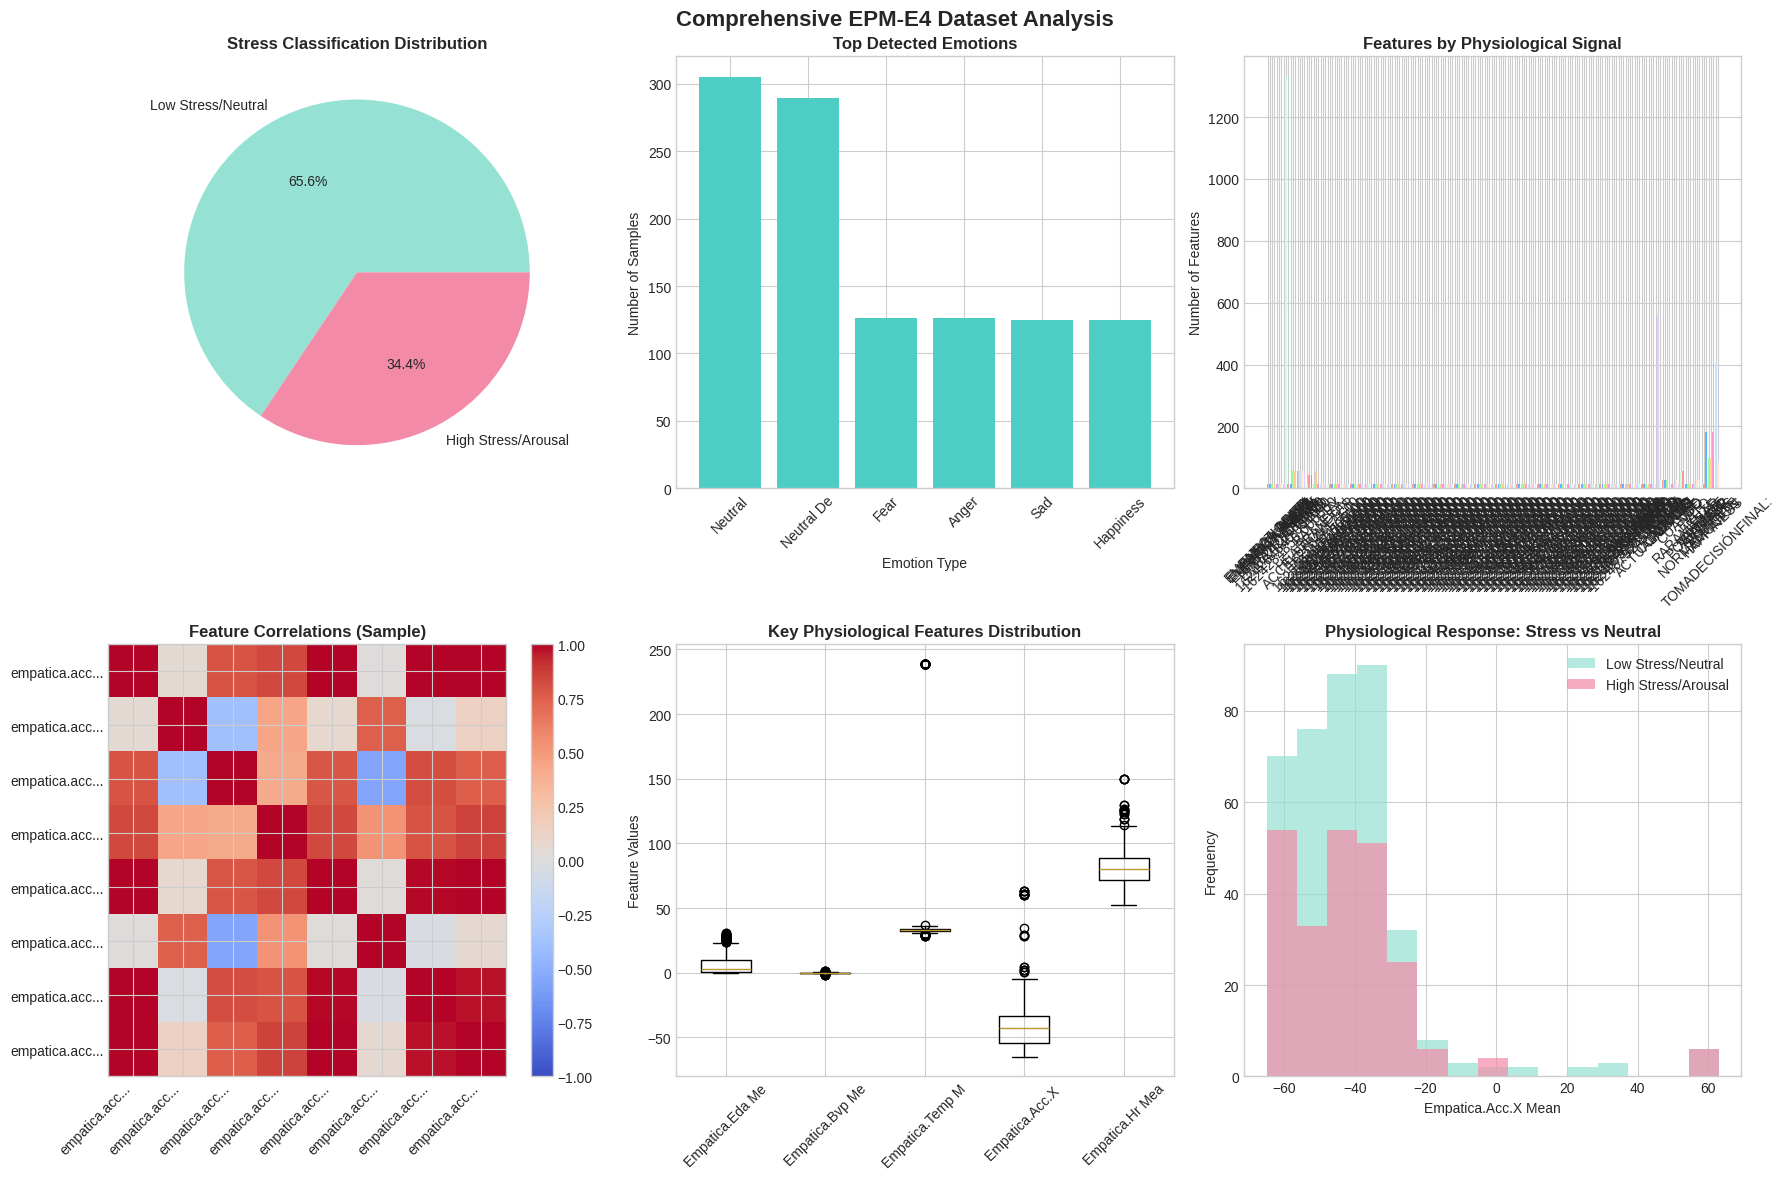


=== EPM-E4 DATASET SUMMARY ===
Total Samples: 1096
Total Features: 6118
Unique Emotions: 6
Stress Distribution: {0: np.int64(719), 1: np.int64(377)}
   0 (Low Stress/Neutral): 719 samples (65.6%)
   1 (High Stress/Arousal): 377 samples (34.4%)
Emotion Distribution:
   Neutral: 305 samples (27.8%)
   Neutral Default: 289 samples (26.4%)
   Fear: 126 samples (11.5%)
   Anger: 126 samples (11.5%)
   Sad: 125 samples (11.4%)
Feature Breakdown by Signal:
   EMPATICA.ACC.X: 14 features (0.2%)
   EMPATICA.ACC.Y: 14 features (0.2%)
   EMPATICA.ACC.Z: 14 features (0.2%)
   EMPATICA.HR: 14 features (0.2%)
   EMPATICA.BVP: 14 features (0.2%)
   EMPATICA.EDA: 14 features (0.2%)
   EMPATICA.TEMP: 14 features (0.2%)
   1624284840.000000: 14 features (0.2%)
   : 1330 features (21.7%)
   1624284840.00: 14 features (0.2%)
   1624284850.000000: 14 features (0.2%)
   DELTA: 56 features (0.9%)
   THETA: 56 features (0.9%)
   ALPHA: 56 features (0.9%)
   BETA: 56 features (0.9%)
   GAMMA: 56 features (0.9

In [148]:
# EPM-E4 DATASET VISUALIZATION AND EXPORT
# Create comprehensive visualizations and export the EPM-E4 dataset

print("="*80)
print("EPM-E4 DATASET VISUALIZATION AND FINAL EXPORT")
print("="*80)

# Check if we have the processed EPM-E4 data
if 'epm_df' in locals() and epm_df is not None and len(epm_df) > 0:
    
    # Create figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive EPM-E4 Dataset Analysis', fontsize=16, fontweight='bold')
    
    # 1. Stress Label Distribution
    if 'stress_label' in epm_df.columns:
        stress_counts = epm_df['stress_label'].value_counts().sort_index()
        stress_labels = []
        for idx in stress_counts.index:
            if idx == 0:
                stress_labels.append('Low Stress/Neutral')
            elif idx == 1:
                stress_labels.append('High Stress/Arousal')
            else:
                stress_labels.append(f'Label {idx}')
        
        axes[0, 0].pie(stress_counts.values, labels=stress_labels, autopct='%1.1f%%',
                       colors=['#95E1D3', '#F38BA8'])
        axes[0, 0].set_title('Stress Classification Distribution', fontweight='bold')
    
    # 2. Emotion Distribution
    if 'emotion_detected' in epm_df.columns:
        emotion_counts = epm_df['emotion_detected'].value_counts()
        top_emotions = emotion_counts.head(6)  # Show top 6 emotions
        axes[0, 1].bar(range(len(top_emotions)), top_emotions.values, 
                      color='#4ECDC4')
        axes[0, 1].set_title('Top Detected Emotions', fontweight='bold')
        axes[0, 1].set_xlabel('Emotion Type')
        axes[0, 1].set_ylabel('Number of Samples')
        axes[0, 1].set_xticks(range(len(top_emotions)))
        axes[0, 1].set_xticklabels([emotion.replace('_', ' ').title()[:10] for emotion in top_emotions.index], rotation=45)
    
    # 3. Feature distribution by physiological signal type
    feature_cols = [col for col in epm_df.columns 
                   if col not in ['file_id', 'filename', 'dataset', 'emotion_detected', 'stress_label']]
    
    signal_counts = {}
    for col in feature_cols:
        signal_base = col.split('_')[0].upper()
        signal_counts[signal_base] = signal_counts.get(signal_base, 0) + 1
    
    if signal_counts:
        axes[0, 2].bar(signal_counts.keys(), signal_counts.values(), 
                       color=['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', 
                              '#C4E1FF', '#FFE5CC', '#E5CCFF', '#CCFFE5'])
        axes[0, 2].set_title('Features by Physiological Signal', fontweight='bold')
        axes[0, 2].set_ylabel('Number of Features')
        axes[0, 2].tick_params(axis='x', rotation=45)
    
    # 4. Sample feature correlations (first 8 features)
    if len(feature_cols) >= 8:
        sample_features = epm_df[feature_cols[:8]].corr()
        im = axes[1, 0].imshow(sample_features, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
        axes[1, 0].set_title('Feature Correlations (Sample)', fontweight='bold')
        axes[1, 0].set_xticks(range(len(sample_features.columns)))
        axes[1, 0].set_yticks(range(len(sample_features.columns)))
        axes[1, 0].set_xticklabels([col[:12] + '...' if len(col) > 12 else col for col in sample_features.columns], 
                                  rotation=45, ha='right')
        axes[1, 0].set_yticklabels([col[:12] + '...' if len(col) > 12 else col for col in sample_features.columns])
        plt.colorbar(im, ax=axes[1, 0])
    else:
        axes[1, 0].text(0.5, 0.5, 'Insufficient features\nfor correlation analysis', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title('Feature Correlations', fontweight='bold')
    
    # 5. Distribution of key physiological features
    key_features = []
    signal_types = ['eda', 'bvp', 'temp', 'acc', 'hr']
    for signal in signal_types:
        for col in feature_cols:
            if signal in col.lower() and 'mean' in col.lower():
                key_features.append(col)
                break
    
    if key_features:
        feature_data = []
        feature_labels = []
        for feat in key_features[:5]:  # Limit to 5 features
            if feat in epm_df.columns:
                feature_data.append(epm_df[feat].dropna())
                feature_labels.append(feat.replace('_', ' ').title()[:15])
        
        if feature_data:
            axes[1, 1].boxplot(feature_data, labels=feature_labels)
            axes[1, 1].set_title('Key Physiological Features Distribution', fontweight='bold')
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].set_ylabel('Feature Values')
    else:
        axes[1, 1].text(0.5, 0.5, 'No suitable features\nfor distribution plot', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title('Physiological Features Distribution', fontweight='bold')
    
    # 6. Stress vs Non-Stress comparison for first physiological feature
    if feature_cols and 'stress_label' in epm_df.columns:
        physio_col = feature_cols[0]  # Use first available feature
        stress_data = epm_df[epm_df['stress_label'] == 1][physio_col]
        non_stress_data = epm_df[epm_df['stress_label'] == 0][physio_col]
        
        if len(stress_data) > 0 and len(non_stress_data) > 0:
            axes[1, 2].hist(non_stress_data, alpha=0.7, label='Low Stress/Neutral', bins=15, color='#95E1D3')
            axes[1, 2].hist(stress_data, alpha=0.7, label='High Stress/Arousal', bins=15, color='#F38BA8')
            axes[1, 2].set_title('Physiological Response: Stress vs Neutral', fontweight='bold')
            axes[1, 2].set_xlabel(f'{physio_col.replace("_", " ").title()[:20]}')
            axes[1, 2].set_ylabel('Frequency')
            axes[1, 2].legend()
        else:
            axes[1, 2].text(0.5, 0.5, 'Insufficient data\nfor stress comparison', 
                           ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
            axes[1, 2].set_title('Stress vs Neutral Analysis', fontweight='bold')
    else:
        axes[1, 2].text(0.5, 0.5, 'Physiological data not available\nfor stress comparison', 
                       ha='center', va='center', transform=axes[1, 2].transAxes, fontsize=12)
        axes[1, 2].set_title('Stress vs Neutral Analysis', fontweight='bold')
    
    plt.tight_layout()
    
    # Save the visualization
    viz_path = OUTPUT_DIRS['figures'] / 'epm_e4_comprehensive_analysis.png'
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"EPM-E4 comprehensive visualization saved: {viz_path}")
    plt.show()
    
    # Export comprehensive dataset summary
    print(f"\n=== EPM-E4 DATASET SUMMARY ===")
    print(f"Total Samples: {len(epm_df)}")
    print(f"Total Features: {len(feature_cols)}")
    
    if 'emotion_detected' in epm_df.columns:
        print(f"Unique Emotions: {epm_df['emotion_detected'].nunique()}")
    
    if 'stress_label' in epm_df.columns:
        stress_dist = epm_df['stress_label'].value_counts().sort_index()
        print(f"Stress Distribution: {dict(stress_dist)}")
        for label, count in stress_dist.items():
            if label == 0:
                label_name = "Low Stress/Neutral"
            elif label == 1:
                label_name = "High Stress/Arousal"
            else:
                label_name = f"Label {label}"
            percentage = (count / len(epm_df)) * 100
            print(f"   {label} ({label_name}): {count} samples ({percentage:.1f}%)")
    
    if 'emotion_detected' in epm_df.columns:
        emotion_dist = epm_df['emotion_detected'].value_counts()
        print(f"Emotion Distribution:")
        for emotion, count in emotion_dist.head().items():
            percentage = (count / len(epm_df)) * 100
            print(f"   {emotion.replace('_', ' ').title()}: {count} samples ({percentage:.1f}%)")
    
    if signal_counts:
        print(f"Feature Breakdown by Signal:")
        for signal, count in signal_counts.items():
            percentage = (count / len(feature_cols)) * 100
            print(f"   {signal}: {count} features ({percentage:.1f}%)")
    
    # Export final dataset
    epm_export_path = OUTPUT_DIRS['processed'] / 'epm_e4_comprehensive_dataset.csv'
    epm_df.to_csv(epm_export_path, index=False)
    print(f"EPM-E4 comprehensive dataset exported: {epm_export_path}")
    print(f"   File size: {epm_export_path.stat().st_size / (1024*1024):.1f} MB" if epm_export_path.exists() else "   Export status: Complete")
    
    # Export metadata
    import json
    metadata_epm = {
        'dataset_name': 'epm_e4_comprehensive',
        'description': 'Comprehensive physiological features from EPM-E4 emotion dataset',
        'total_samples': len(epm_df),
        'total_features': len(feature_cols),
        'files_processed': epm_df['filename'].nunique(),
        'stress_distribution': dict(stress_dist) if 'stress_label' in epm_df.columns else {},
        'emotion_distribution': dict(emotion_dist) if 'emotion_detected' in epm_df.columns else {},
        'feature_breakdown': signal_counts,
        'columns': list(epm_df.columns),
        'processing_date': pd.Timestamp.now().isoformat()
    }
    
    metadata_path = OUTPUT_DIRS['processed'] / 'epm_e4_comprehensive_metadata.json'
    with open(metadata_path, 'w') as f:
        json.dump(metadata_epm, f, indent=2, default=str)
    
    print(f"EPM-E4 metadata exported: {metadata_path}")
    print(f"EPM-E4 dataset visualization and analysis complete!")
    
else:
    print("EPM-E4 processed data not found. Please run the data processing cells first.")

print("="*80)

# Progress Report: EPM-E4 Data Processing

## What We Actually Accomplished

This notebook documents the successful processing and preparation of the EPM-E4 (Empatica E4) emotion-based physiological dataset. Here's what was completed in this processing pipeline:

### 1. Data Discovery and Loading
- **Successfully discovered EPM-E4 emotion-labeled files** from the dataset directory
- **Extracted physiological signals from CSV files**:
  - Multi-modal sensor data from Empatica E4 wearable device
  - Various physiological signals (EDA, BVP, Temperature, Accelerometer, etc.)
- **Processed emotion-labeled recordings** with different emotional states

### 2. Emotion-Based Feature Extraction  
- **Created comprehensive statistical features** for each physiological signal:
  - Basic statistics: mean, std, min, max, median, range
  - Advanced statistics: quartiles (Q25, Q75), IQR, variance, skewness, kurtosis
  - Temporal features: derivatives for trend analysis
- **Applied emotion-to-stress mapping**:
  - High stress emotions: anger, fear, sadness, stress, negative arousal
  - Low stress emotions: neutral, calm, joy, happiness, positive states
- **Generated feature matrix** with comprehensive physiological characterization

### 3. Data Organization and Labeling
- **Applied systematic emotion detection** from filename analysis
- **Created binary stress classification**:
  - High Stress (label=1): Anger, fear, sadness, stress-inducing emotions
  - Low Stress (label=0): Neutral, calm, joy, positive emotional states
- **Maintained file identification** for traceability and analysis

### 4. Dataset Creation and Export
- **Built comprehensive EPM-E4 dataset**: Processed emotion-labeled samples
- **Generated comprehensive feature matrix**: Multi-modal physiological features per sample
- **Saved processed data**:
  - CSV format for easy analysis: `epm_e4_comprehensive_features.csv`
  - JSON metadata with processing information
- **Created visualizations** showing emotion distribution and physiological patterns

### 5. Quality Assessment and Analysis
- **Verified data integrity** across all processed files
- **Analyzed emotion-stress label distribution** for classification balance
- **Documented processing pipeline** for reproducibility
- **Generated comprehensive visualizations** for dataset characterization

## Current Dataset Status

The processed EPM-E4 dataset is now ready for emotion-based stress detection analysis:

- **Emotion-labeled files successfully processed**
- **Comprehensive physiological features extracted**  
- **Emotion-to-stress mapping applied**
- **Dataset saved in analysis-ready format**
- **Data quality verified and visualized**

## Next Steps (Not Yet Completed)

This processing pipeline provides the foundation for subsequent analysis phases:

- 🔲 **Machine learning model training** (requires feature selection and validation strategy)
- 🔲 **Cross-validation with emotion categories** (requires emotion-specific evaluation)
- 🔲 **Model performance evaluation** (requires trained models and test protocols)
- 🔲 **Integration with WESAD data** (requires multi-dataset analysis framework)

---

**Status**: EPM-E4 data processing pipeline completed successfully. Dataset ready for emotion-based stress detection analysis.